In [39]:
# Plot all matches of a template recorded by a given station

In [40]:
## import modules
from matplotlib.pyplot import subplots
from matplotlib import ticker
from obspy import read, UTCDateTime
from utils_snuffler import read_normal_markers
from utils_preproc import read_and_process_template_waveforms, read_and_process_match_waveforms
from utils_spec import get_data_spectrum, get_filter_response
from utils_cc import read_template_and_match, get_timewin_from_template_name
from pandas import DataFrame
from os.path import join
from numpy import amax, abs
from re import search

In [41]:
## Inputs
tempname = "HighB16-22-01-27"
suffix = "bandpass10-450hz_dur0.05s_mincc0.7_mindet1"
rootdir = "/Volumes/OmanData/geophones_no_prefilt/data"

stations = ["B13"]
component = "Z"

begin = -0.02
end = 0.2

scale_ax = 3

linewidth = 0.5

In [42]:
## Read the template and match information

### Extract the time window of the template
timewin = get_timewin_from_template_name(tempname)

### Read the file
inpath = join(rootdir, timewin, f"ccmatches_{tempname}_{suffix}.dat")
template_and_match = read_template_and_match(inpath)


In [43]:
## Read and process the template waveform

### Extract the frequency band from the suffix
if "bandpass" in suffix:
    pattern = r"bandpass(\d+)-(\d+)hz"
    match = search(pattern, suffix)
    if match:
        freqmin = float(match.group(1))
        freqmax = float(match.group(2))
    else:
        raise ValueError("No frequency band information found in the suffix")

template = template_and_match.template
template_waveforms = read_and_process_template_waveforms(template, freqmin, freqmax, stations=stations, components=[component], begin=begin, end=end,  rootdir=rootdir)

In [44]:
## Read an process the match waveforms
matches = template_and_match.matches
match_waveforms = read_and_process_match_waveforms(matches, freqmin, freqmax, stations=stations, components=[component], begin=begin, end=end)

Processed 1 of 2666 matches!
Processed 2 of 2666 matches!
Processed 3 of 2666 matches!
Processed 4 of 2666 matches!
Processed 5 of 2666 matches!
Processed 6 of 2666 matches!
Processed 7 of 2666 matches!
Processed 8 of 2666 matches!
Processed 9 of 2666 matches!
Processed 10 of 2666 matches!
Processed 11 of 2666 matches!
Processed 12 of 2666 matches!
Processed 13 of 2666 matches!
Processed 14 of 2666 matches!
Processed 15 of 2666 matches!
Processed 16 of 2666 matches!
Processed 17 of 2666 matches!
Processed 18 of 2666 matches!
Processed 19 of 2666 matches!
Processed 20 of 2666 matches!
Processed 21 of 2666 matches!
Processed 22 of 2666 matches!
Processed 23 of 2666 matches!
Processed 24 of 2666 matches!
Processed 25 of 2666 matches!
Processed 26 of 2666 matches!
Processed 27 of 2666 matches!
Processed 28 of 2666 matches!
Processed 29 of 2666 matches!
Processed 30 of 2666 matches!
Processed 31 of 2666 matches!
Processed 32 of 2666 matches!
Processed 33 of 2666 matches!
Processed 34 of 266

In [45]:
## Extract the waveforms of all matches and store them in arrays
arraydict = match_waveforms.to_arrays(component=component, normalize=False)

## Normalize each trace by the maximum in the window used for cross-correlation
trace = template_waveforms.waveforms.select(station=stations[0], component=component)[0]
data = trace.data
timeax = trace.times()+begin
dur = template_waveforms.info.duration

for station in stations:
    matchmat = arraydict[station]
    numev = matchmat.shape[0]
    for i in range(numev):
        matchmat[i, :] = matchmat[i, :] / amax(abs(matchmat[i, (timeax > 0) & (timeax < dur)]))

Saving figure to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-16-22-00-00/all_matches_HighB16-22-01-27_bandpass10-450hz_dur0.05s_mincc0.7_mindet1_Z.png


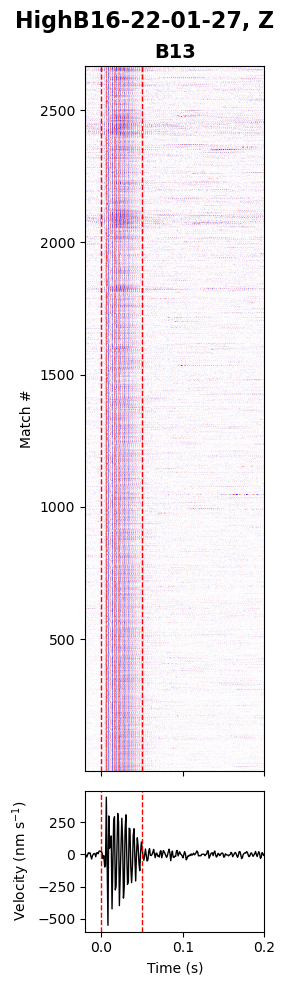

In [47]:
## Plot the template and match waveforms
numsta = len(stations)

fig, axes = subplots(2, numsta, figsize=(scale_ax*numsta, 10), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

for i, station in enumerate(stations):

    ### Plot the match waveforms on the top subplot
    if numsta == 1:
        ax = axes[0]
    else:
        ax = axes[0, i]

    matchmat = arraydict[station]

    ax.set_facecolor('lightgrey')
    ax.imshow(matchmat, aspect='auto', cmap='bwr', extent=[begin, end, 1, numev], origin='lower', vmin=-1, vmax=1)

    if i == 0:
        ax.set_ylabel("Match #")

    ax.set_title(f"{station}", fontsize=14, fontweight='bold')

    ax.axvline(0, color='red', linewidth=1, linestyle='--')
    ax.axvline(dur, color='red', linewidth=1, linestyle='--')

    ### Plot the template waveform on the bottom subplot
    if numsta == 1:
        ax = axes[1]
    else:
        ax = axes[1, i]
        
    trace = template_waveforms.waveforms.select(station=station, component=component)[0]
    data = trace.data
    timeax = trace.times()+begin

    ax.plot(timeax, data, color='black', linewidth=1)

    ax.axvline(0, color='red', linewidth=1, linestyle='--')
    ax.axvline(dur, color='red', linewidth=1, linestyle='--')

    ax.set_xlim(begin, end)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Velocity (nm s$^{-1}$)")

fig.suptitle(f"{tempname}, {component}", fontsize=16, fontweight='bold')

## Save the figure
fig.patch.set_alpha(0)
fig.tight_layout()

outpath = join(rootdir, timewin, f"all_matches_{tempname}_{suffix}_{component}.png")
fig.savefig(outpath, dpi=300)
print(f"Saving figure to {outpath}")

In [ ]:
for event in match_waveforms:
    stations = event.info.stations
    stations_set = set(stations)
    if len(stations) != len(stations_set):
        print(event)
